In [ ]:
!pip install tensorflow matplotlib

In [ ]:
!pip install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset_augmented"

In [ ]:
!ls /content/drive/MyDrive/Colab_Notebooks/dataset_augmented

test  train  val


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# -----------------------------
# Mixed Precision (faster on GPU)
# -----------------------------
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# -----------------------------
# Parameters
# -----------------------------
img_size = (128, 128)
batch_size = 32
num_classes = 4
epochs_initial = 5
epochs_finetune = 10
fine_tune_at = 100


In [ ]:
# -----------------------------
# Load datasets (train/val/test)
# -----------------------------
train_ds = image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int",
    shuffle=True,
    seed=42
)

val_ds = image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int",
    shuffle=True,
    seed=42
)

test_ds = image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    image_size=img_size,
    batch_size=batch_size,
    label_mode="int",
    shuffle=False
)

# -----------------------------
# Shuffle & Prefetch
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(buffer_size=10000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


Found 3200 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


In [ ]:
# -----------------------------
# Compute Class Weights
# -----------------------------
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

from collections import Counter
label_counts = Counter(all_labels)
total = sum(label_counts.values())
class_weights = {cls: total / (num_classes * count) for cls, count in label_counts.items()}
print("⚖️ Class Weights:", class_weights)


⚖️ Class Weights: {2: 1.0, 1: 1.0, 0: 1.0, 3: 1.0}


In [ ]:
# -----------------------------
# Data Augmentation
# -----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])


In [ ]:
# -----------------------------
# Build Model (MobileNetV2)
# -----------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)  # prevent overfitting
outputs = layers.Dense(
    num_classes,
    activation="softmax",
    dtype="float32",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,228 (8.65 MB)

 Trainable params: 7,684 (30.02 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
# -----------------------------
# Callbacks
# -----------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor="val_loss")
]


In [ ]:
# -----------------------------
# Train classifier head
# -----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_initial,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.6410 - loss: 1.0280 - val_accuracy: 0.9600 - val_loss: 0.1318 - learning_rate: 0.0010
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.8948 - loss: 0.3190 - val_accuracy: 0.9750 - val_loss: 0.0875 - learning_rate: 0.0010
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.9153 - loss: 0.2415 - val_accuracy: 0.9750 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.9282 - loss: 0.2294 - val_accuracy: 0.9725 - val_loss: 0.0828 - learning_rate: 0.0010
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9348 - loss: 0.1809 - val_accuracy: 0.9700 - val_loss: 0.1019 - learning_rate: 0.0010


In [ ]:
# -----------------------------
# Fine-tune base model
# -----------------------------
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_finetune,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1677s 17s/step - accuracy: 0.8667 - loss: 0.3768 - val_accuracy: 0.9725 - val_loss: 0.0655 - learning_rate: 1.0000e-05
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1654s 16s/step - accuracy: 0.8969 - loss: 0.2903 - val_accuracy: 0.9700 - val_loss: 0.0687 - learning_rate: 1.0000e-05
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1708s 17s/step - accuracy: 0.9130 - loss: 0.2493 - val_accuracy: 0.9725 - val_loss: 0.0657 - learning_rate: 1.0000e-05
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1658s 16s/step - accuracy: 0.9146 - loss: 0.2200 - val_accuracy: 0.9700 - val_loss: 0.0650 - learning_rate: 1.0000e-05
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1685s 16s/step - accuracy: 0.9310 - loss: 0.1815 - val_accuracy: 0.9625 - val_loss: 0.0715 - learning_rate: 1.0000e-05
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1653s 16s/step - accuracy: 0.9353 - loss: 0.1816 - val_accuracy: 0.9650 - val_loss: 0.0696 - learning_rate: 1.0000e-05
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1693s 

13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.9291 - loss: 0.1835
✅ Test Accuracy: 0.9375, Test Loss: 0.1508


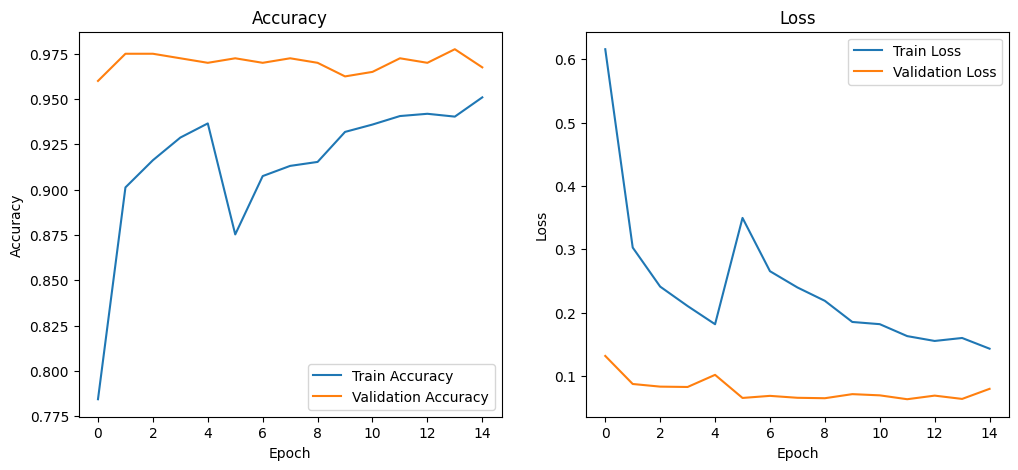

In [ ]:
# -----------------------------
# Evaluate on test set
# -----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# -----------------------------
# Plot Training Curves
# -----------------------------
acc = history.history["accuracy"] + history_finetune.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_finetune.history["val_accuracy"]
loss = history.history["loss"] + history_finetune.history["loss"]
val_loss = history.history["val_loss"] + history_finetune.history["val_loss"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
model.save("/content/drive/MyDrive/Colab_Notebooks/fine_tuned_model.keras")


In [ ]:
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Point to train folder again
temp_ds = image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    image_size=img_size,
    batch_size=1
)

class_names = temp_ds.class_names
print("Class Names:", class_names)


Found 3200 files belonging to 4 classes.
Class Names: ['isolated_crushed_paper_ball', 'isolated_single_banana_peel', 'isolated_single_empty_plastic_bottle', 'isolated_single_pen']


In [ ]:
import tensorflow as tf
import numpy as np
import requests
from PIL import Image
from io import BytesIO

# Load trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/fine_tuned_model.keras")

def predict_from_url(url, img_size=(128, 128)):
    headers = {"User-Agent": "Mozilla/5.0"}  # fake browser agent
    response = requests.get(url, headers=headers, timeout=10)

    # Ensure content is an image
    if "image" not in response.headers.get("Content-Type", ""):
        raise ValueError(f"URL did not return an image. Content-Type: {response.headers.get('Content-Type')}")

    # Open image safely
    img = Image.open(BytesIO(response.content)).convert("RGB")

    # Preprocess
    img = img.resize(img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Prediction
    preds = model.predict(img_array)
    class_id = np.argmax(preds[0])
    confidence = preds[0][class_id]

    return class_names[class_id], confidence

# Example
url = "https://seedballs.in/cdn/shop/files/WhatsAppImage2024-01-05at7.00.10PM.jpg?v=1740203604"
label, confidence = predict_from_url(url)
print(f"Predicted: {label} ({confidence:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: isolated_single_pen (0.9999)


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/fine_tuned_model.keras")

def predict_from_path(img_path, img_size=(128, 128)):
    # Open image safely
    img = Image.open(img_path).convert("RGB")

    # Preprocess
    img = img.resize(img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Prediction
    preds = model.predict(img_array)
    class_id = np.argmax(preds[0])
    confidence = preds[0][class_id]

    return class_names[class_id], confidence

# -----------------------------
# Example usage (Google Drive path)
# -----------------------------
img_path = "/content/drive/MyDrive/Colab_Notebooks/test_images/ball.png"  # replace with your file path
label, confidence = predict_from_path(img_path)
print(f"Predicted: {label} ({confidence:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: isolated_crushed_paper_ball (0.9999)


In [ ]:
import tensorflow as tf
from keras.models import model_from_json

keras.backend.clear_session()

# Model reconstruction from JSON file.
with open('model.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights from h5 file.
model.load_weights('model.h5')

# Print summary.
model.summary()

# Save model and weights in a h5 file, then load again using tf.keras.
model.save('model_full.h5')
model = tf.keras.models.load_model('model_full.h5', compile=False)

# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

NameError: name 'keras' is not defined